In [0]:
!git clone https://www.github.com/ildoonet/tf-pose-estimation
%cd tf-pose-estimation
!pip install -r requirements.txt
!sudo apt install swig
%cd tf_pose/pafprocess/
!swig -python -c++ pafprocess.i && python3 setup.py build_ext --inplace
%cd ..
%cd ..

In [0]:
%cd models/graph/cmu
!bash download.sh
%cd /content/tf-pose-estimation

In [0]:
import tf_pose
from tf_pose import common
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from PIL import Image, ImageDraw

def get_w_h(x):
    return model_wh(x)

def get_p_estimator(x,w,h):
    return TfPoseEstimator(get_graph_path(x), target_size=(w, h))

def get_np_img(x):
    return common.read_imgfile(x, None, None)

def get_draw_humans(x,y):
	return TfPoseEstimator.draw_humans(x, y, imgcopy=False)

def round_down(num, divisor):
    return num - (num%divisor)

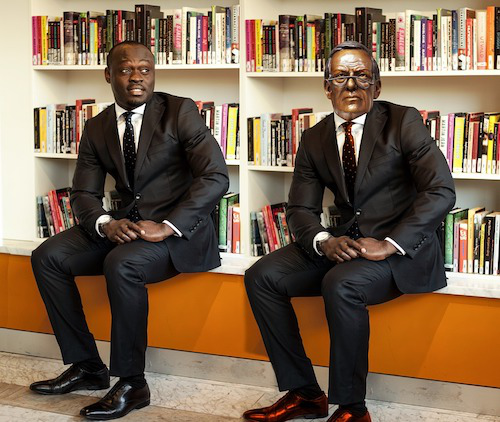

In [177]:
image_path = "./images/p2.jpg"

Image.open(image_path)

In [178]:
images = [image_path]


#y = "mobilenet_thin"
y = "cmu"

detect_size = True
z = "432x368"
#z = "656x368"
#z = "1312x736"

estimated_data = []
for i in images:
    if detect_size == True:
        image_size = Image.open(i).size
        rounded_w = round_down(image_size[0],16)
        rounded_h = round_down(image_size[1],16)
        z = "{}x{}".format(str(rounded_w),str(rounded_h))
        w,h = rounded_w, rounded_h
        e = get_p_estimator(y,w,h)
        n_image = get_np_img(i)
        humans = e.inference(n_image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
        estimated_data.append(humans)
    else:
        image_size = Image.open(i).size
        w,h = get_w_h(z)
        e = get_p_estimator(y,w,h)
        n_image = get_np_img(i)
        humans = e.inference(n_image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
        estimated_data.append(humans)
        image = get_draw_humans(n_image,humans)
        
        


[2019-07-03 07:21:05,511] [TfPoseEstimator] [INFO] loading graph from /content/tf-pose-estimation/models/graph/cmu/graph_opt.pb(default size=496x416)
I0703 07:21:05.511512 140652493526912 estimator.py:309] loading graph from /content/tf-pose-estimation/models/graph/cmu/graph_opt.pb(default size=496x416)


In [179]:
arranged_estimated_data = []
for i in estimated_data:
    if len(i) > 1:
        print(i)
        for i2 in i:
            arranged_estimated_data.append([i2])
    else:
        arranged_estimated_data.append(i)

[BodyPart:0-(0.71, 0.21) score=0.78 BodyPart:1-(0.71, 0.30) score=0.69 BodyPart:2-(0.62, 0.34) score=0.70 BodyPart:3-(0.60, 0.51) score=0.68 BodyPart:4-(0.65, 0.57) score=0.75 BodyPart:5-(0.81, 0.28) score=0.62 BodyPart:6-(0.89, 0.46) score=0.72 BodyPart:7-(0.77, 0.59) score=0.65 BodyPart:8-(0.67, 0.58) score=0.22 BodyPart:9-(0.53, 0.66) score=0.66 BodyPart:10-(0.60, 0.92) score=0.47 BodyPart:11-(0.81, 0.60) score=0.37 BodyPart:12-(0.69, 0.67) score=0.70 BodyPart:13-(0.69, 0.96) score=0.45 BodyPart:14-(0.69, 0.18) score=0.75 BodyPart:15-(0.72, 0.18) score=0.80 BodyPart:16-(0.66, 0.21) score=0.74 BodyPart:17-(0.75, 0.21) score=0.77, BodyPart:0-(0.27, 0.18) score=0.78 BodyPart:1-(0.27, 0.28) score=0.68 BodyPart:2-(0.19, 0.30) score=0.59 BodyPart:3-(0.16, 0.47) score=0.70 BodyPart:4-(0.21, 0.52) score=0.80 BodyPart:5-(0.36, 0.26) score=0.68 BodyPart:6-(0.44, 0.42) score=0.72 BodyPart:7-(0.33, 0.54) score=0.54 BodyPart:8-(0.22, 0.54) score=0.29 BodyPart:9-(0.10, 0.61) score=0.71 BodyPart:1

In [0]:
import re
import numpy as np

pattern = '\(.+?\)'
box_data = []

#パーツ指定。デフォルトはNone
parts_number = [4,7,9,10,12,13]
# 0   Nose　　　　　　　　　　　 鼻
# 1   Neck 　　　　　　　　　　　首
# 2   RShoulder　　　 右肩
# 3   RElbow 　　　　　　　　右肘
# 4   RWrist 　　　　　　　　　右手首
# 5   LShoulder 　　　左肩
# 6   LElbow 　　　　　　　　左肘
# 7   LWrist 　　　　　　　　　左手首
# 8   RHip 　　　　　　　　　　　　右腰
# 9   RKnee 　　　　　　　　　右膝
# 10 RAnkle 　　　　　　　　右足首
# 11 LHip 　　　　　　　　　　　　左腰
# 12 LKnee 　　　　　　　　　左膝
# 13 LAnkle 　　　　　　　　左足首
# 14 REye 　　　　　　　　　　　右目
# 15 LEye 　　　　　　　　　　　左目
# 16 REar 　　　　　　　　　　　　右耳
# 17 LEar 　　　　　　　　　　　　左耳
# 18 Background 背景

original_image_h = image_size[0]
original_image_w = image_size[1]

for i in arranged_estimated_data:
    if parts_number == None :
        #パーツを全て取り出すループ
        for n in range(19):
            try:
                #パーツ部分を抽出
                a = i[0].body_parts[n]
                #()に囲まれている部分を抽出
                a2 = re.search(pattern, str(a))
                #()を削除し,数値を２つに分割
                t,g = a2.group().strip("("")").split(",")
                t = int(float(t)*original_image_h)
                g = int(float(g)*original_image_w)
                _list = [n,np.array([t-4,g-4,t+4,g+4])]
                box_data.append(_list)
            except:
                pass
    #パーツ指定がある場合
    else:
        for n in parts_number:
            try:
                a = i[0].body_parts[n]
                #()に囲まれている部分を抽出
                a2 = re.search(pattern, str(a))
                #()を削除し,数値を２つに分割
                t,g = a2.group().strip("("")").split(",")
                t = int(float(t)*original_image_h)
                g = int(float(g)*original_image_w)
                _list = [n,np.array([t-4,g-4,t+4,g+4])]
                box_data.append(_list)
            except:
                pass


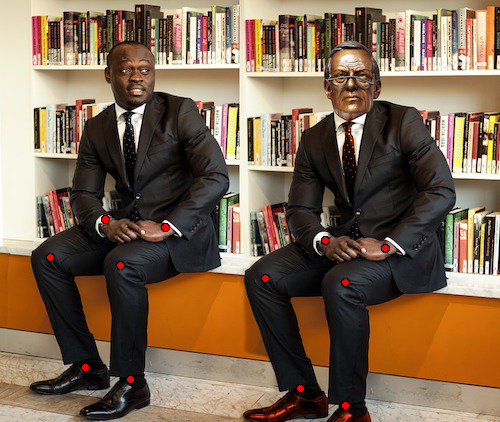

In [181]:
im = Image.open(image_path)
draw = ImageDraw.Draw(im)
for i in box_data:
    dd = tuple(i[1])
    draw.ellipse(dd, fill=(255, 0, 0), outline=(0, 0, 0))

im
# im.save('imagedraw.jpg', quality=95)
# Image.open("imagedraw.jpg")